## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
from tensorflow import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], rdb="BatchNormalization"):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if rdb == "l1":
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(1e-8))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(input_layer)
            if rdb == "Dropout":
                x = Dropout(0.2)(x)
            if rdb == "BatchNormalization":
                x = BatchNormalization()(x)
        else:
            if rdb == "l1":
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(1e-8))(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(x)
            if rdb == "Dropout":
                x = Dropout(0.2)(x)
            if rdb == "BatchNormalization":
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
RDB=["none","l1","Dropout","BatchNormalization"]

In [9]:
results={}
for rdb in RDB:
    model = build_mlp(input_shape=x_train.shape[1:],rdb=rdb)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    exp_name_tag = "overfit-%s" % rdb
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 20s 396

Epoch 48/50
50000/50000 [==============================] - 17s 332us/sample - loss: 0.9012 - accuracy: 0.6832 - val_loss: 1.3909 - val_accuracy: 0.5276
Epoch 49/50
50000/50000 [==============================] - 16s 316us/sample - loss: 0.8906 - accuracy: 0.6860 - val_loss: 1.3515 - val_accuracy: 0.5417
Epoch 50/50
50000/50000 [==============================] - 16s 321us/sample - loss: 0.8820 - accuracy: 0.6912 - val_loss: 1.3848 - val_accuracy: 0.5370
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________

Epoch 45/50
50000/50000 [==============================] - 22s 433us/sample - loss: 0.9309 - accuracy: 0.6739 - val_loss: 1.3837 - val_accuracy: 0.5217
Epoch 46/50
50000/50000 [==============================] - 22s 439us/sample - loss: 0.9196 - accuracy: 0.6787 - val_loss: 1.4591 - val_accuracy: 0.5101
Epoch 47/50
50000/50000 [==============================] - 22s 446us/sample - loss: 0.9006 - accuracy: 0.6852 - val_loss: 1.4910 - val_accuracy: 0.4990
Epoch 48/50
50000/50000 [==============================] - 22s 436us/sample - loss: 0.8913 - accuracy: 0.6880 - val_loss: 1.4559 - val_accuracy: 0.5094
Epoch 49/50
50000/50000 [==============================] - 22s 440us/sample - loss: 0.8814 - accuracy: 0.6910 - val_loss: 1.4291 - val_accuracy: 0.5257
Epoch 50/50
50000/50000 [==============================] - 22s 444us/sample - loss: 0.8695 - accuracy: 0.6982 - val_loss: 1.4030 - val_accuracy: 0.5299
Model: "model_3"
_________________________________________________________________
Layer

50000/50000 [==============================] - 20s 393us/sample - loss: 1.3055 - accuracy: 0.5359 - val_loss: 1.3444 - val_accuracy: 0.5217
Epoch 40/50
50000/50000 [==============================] - 20s 398us/sample - loss: 1.2995 - accuracy: 0.5335 - val_loss: 1.3214 - val_accuracy: 0.5283
Epoch 41/50
50000/50000 [==============================] - 20s 391us/sample - loss: 1.2951 - accuracy: 0.5369 - val_loss: 1.3264 - val_accuracy: 0.5289
Epoch 42/50
50000/50000 [==============================] - 19s 377us/sample - loss: 1.2838 - accuracy: 0.5393 - val_loss: 1.3091 - val_accuracy: 0.5362
Epoch 43/50
50000/50000 [==============================] - 19s 388us/sample - loss: 1.2732 - accuracy: 0.5461 - val_loss: 1.3082 - val_accuracy: 0.5333
Epoch 44/50
50000/50000 [==============================] - 19s 386us/sample - loss: 1.2675 - accuracy: 0.5479 - val_loss: 1.3228 - val_accuracy: 0.5314
Epoch 45/50
50000/50000 [==============================] - 20s 399us/sample - loss: 1.2633 - accurac

50000/50000 [==============================] - 21s 412us/sample - loss: 0.4179 - accuracy: 0.8665 - val_loss: 1.8781 - val_accuracy: 0.4724
Epoch 34/50
50000/50000 [==============================] - 20s 409us/sample - loss: 0.3972 - accuracy: 0.8757 - val_loss: 1.9171 - val_accuracy: 0.4831
Epoch 35/50
50000/50000 [==============================] - 21s 417us/sample - loss: 0.3777 - accuracy: 0.8822 - val_loss: 2.0054 - val_accuracy: 0.4698
Epoch 36/50
50000/50000 [==============================] - 20s 409us/sample - loss: 0.3617 - accuracy: 0.8855 - val_loss: 2.0320 - val_accuracy: 0.4619
Epoch 37/50
50000/50000 [==============================] - 19s 378us/sample - loss: 0.3420 - accuracy: 0.8944 - val_loss: 2.0292 - val_accuracy: 0.4785
Epoch 38/50
50000/50000 [==============================] - 14s 286us/sample - loss: 0.3297 - accuracy: 0.8964 - val_loss: 2.0569 - val_accuracy: 0.4810
Epoch 39/50
50000/50000 [==============================] - 20s 392us/sample - loss: 0.3067 - accurac

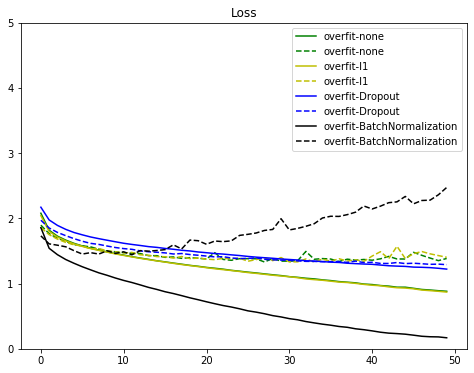

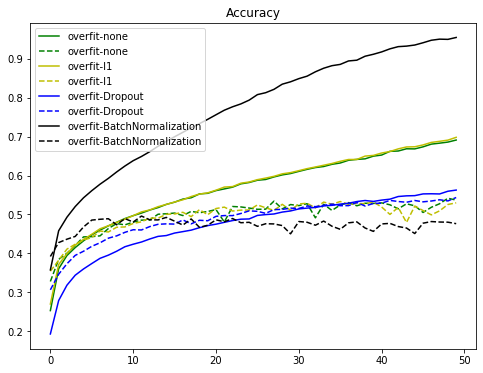

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["g", "y", "b","k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()